In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import fastcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [2]:
# Configuración de números flotantes a 3 decimales
pd.set_option('display.float_format','{:.2f}'.format)

# Estilo de visualización
sns.set_style("darkgrid")#, {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
DATA_PATH = os.path.join('../datasets/processed/rfm_dataset.csv')

In [4]:
data = pd.read_csv(DATA_PATH, index_col='Customer ID')
data.head()

,Recency,Frequency,MonetaryValue
Customer ID,,,
AA-10315,185,11,-362.88
AA-10375,20,15,277.38
AA-10480,260,12,435.83
AA-10645,56,18,857.80
AB-10015,416,6,129.35


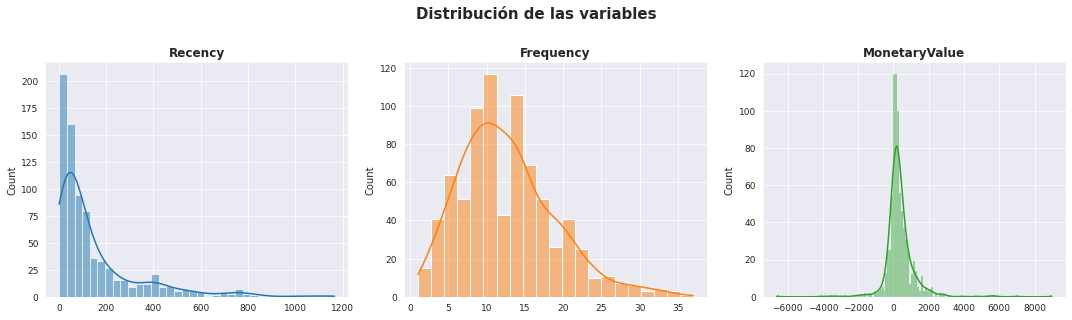

In [5]:
%run ../auxiliar_functions/plotDistributions.py
    
plotDistributions(data, 'Distribución de las variables')

### Transformación de los datos

In [6]:
# Yeo-Johnson Transformation
pt = PowerTransformer(method='box-cox')
ms = MinMaxScaler(feature_range=(-3,3))

transformer = ColumnTransformer(transformers=[('box-cox', pt, ['Recency']),
                              ('standarizer', ms, [1, 2])])

scaled = transformer.fit_transform(data)

# Variables escaladas - DataFrame
scaled = pd.DataFrame(scaled, index=data.index, columns=data.columns)
scaled.sample(5)

,Recency,Frequency,MonetaryValue
Customer ID,,,
AG-10900,0.17,0.33,-0.32
TB-21400,0.78,-0.33,0.62
RB-19570,-0.81,-1.67,-0.42
SO-20335,-0.71,-0.67,-0.48
HE-14800,-1.28,-1.33,-0.35


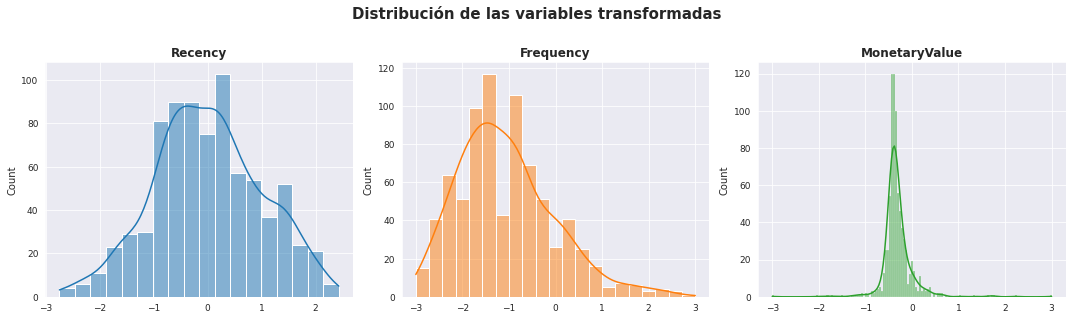

In [7]:
plotDistributions(scaled, 'Distribución de las variables transformadas')

In [8]:
scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,793.00,0.00,1.00,-2.74,-0.69,-0.02,0.70,2.43
Frequency,793.00,-1.07,1.04,-3.00,-1.83,-1.17,-0.50,3.00
MonetaryValue,793.00,-0.31,0.34,-3.00,-0.44,-0.37,-0.24,3.00


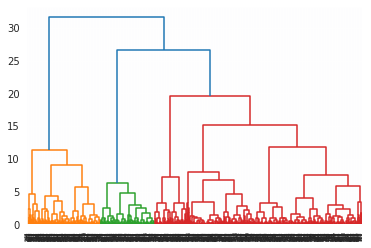

In [9]:
# Modelo de segmentación jerárquica
hierarchy_model = fastcluster.linkage_vector(scaled, method='ward', metric='euclidean')

# Dendrograma
drendogram = dendrogram(hierarchy_model)

# Visualización del dendrograma
plt.show()

In [10]:
# Punto de corte
cluster_labels = fcluster(hierarchy_model, 13, criterion='distance')

hierarchicalData = data.copy()

# Asignación de las etiquetas de clusters a los datos
hierarchicalData['ClusterLabels_H'] = cluster_labels

hierarchicalData = hierarchicalData.groupby('ClusterLabels_H').agg({'Recency':'mean',
                                                   'Frequency':'mean',
                                                   'MonetaryValue':['mean','count']})


hierarchicalData

Recency Frequency MonetaryValue      
                   mean      mean          mean count
ClusterLabels_H                                      
1                 80.97     21.43        532.39   175
2                466.91      6.77        135.28   128
3                  7.44     12.45        497.85    75
4                175.23     12.76        566.28   164
5                 55.69      9.36        182.09   251